In [1]:
!pip install influxdb
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install ruptures

In [2]:
from influxdb import InfluxDBClient
import pandas as pd
# required for learning

import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.utils.validation import check_array
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit

import ruptures as rpt

# required only for ploting
import matplotlib.pyplot as plt
%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize']= 15,6
from datetime import datetime

In [3]:
#Host 1
host = "138.246.232.174"
#Host 2
#host = "138.246.232.219"
port = 8086
user = "root"
password = "root"
#dbname = "nodejs-gc-test-leak" #todo parameterize this

#!mkdir ./plots/$dbname

# make a dictionary of "dbname": "docker image name"
# limit to a 100-200 entries for plotting

imagedict = {
    'nodejs-gc-test-leak': {
        'image' : 'poojakulkarni/nodegctestleak:latest',
        'starttime': '2019-07-20T03:42:21.417Z',
        'endtime': '2019-07-20T06:43:31.417Z'
    }, 
    'script-basic-java-sleep1min-leak':{ # actually 3min sleep
        'image': 'poojakulkarni/javabasicleak3minsleep:latest',
        'starttime': '2019-07-19T12:25:23.172Z',
        'endtime': '2019-07-19T15:26:38.172Z'
    },
    'latest-basic-java-sleep1min-leak':{ # 1min sleep
        'image': 'poojakulkarni/javabasicleak1minsleep:latest',
        'starttime': '2019-07-25T05:18:00.64Z',
        'endtime': '2019-07-25T08:18:10.64Z'
    },
    'script-mem-alloc-cffi-leak-try3':{
        'image': 'poojakulkarni/memallocpyleak:latest',
        'starttime': '2019-07-20T00:38:13.62Z',
        'endtime': '2019-07-20T03:39:28.621Z'
     },
    'noodejs-event-emitter-leak':{
        'image':'poojakulkarni/nodejseventemitterleak:latest',
        'starttime': '2019-07-22T05:11:39.471Z',
        'endtime': '2019-07-22T08:11:49.471Z'
    },
    'script-basic-python-sleep1min-verified-leak':{
        'image': 'poojakulkarni/pythonbasicleak1minsleep:latest',
        'starttime': '2019-07-19T18:31:55.291Z',
        'endtime': '2019-07-19T21:33:05.291Z'
    },
    'nodejs-basic-leak': {
        'image' : 'poojakulkarni/nodejsbasicleak:latest',
        'starttime': '2019-07-22T18:11:01.579Z',
        'endtime': '2019-07-22T21:11:46.579Z'
    },
    # 6 LEAKY FIXES
    'nodejs-gc-test-leakfix': {
        'image' : 'poojakulkarni/nodegctestleakfix:latest',
        'starttime': '2019-07-20T09:48:41.477Z',
        'endtime': '2019-07-20T12:49:56.477Z'
    },
    'script-basic-java-sleep1min-leakfix':{ # 1min sleep
        'image': 'poojakulkarni/javabasicleak1minsleepfix:latest',
        'starttime': '2019-07-19T21:35:03.516Z',
        'endtime': '2019-07-20T00:36:18.516Z'
    },
    'script-mem-alloc-cffi-leakfix':{
        'image': 'poojakulkarni/memallocpyleakfix:latest',
        'starttime': '2019-07-19T15:28:37.552Z',
        'endtime': '2019-07-19T18:29:52.552Z'
     },
    'noodejs-event-emitter-leakfix':{ # 
        'image':'poojakulkarni/nodejseventemitterfix:latest',
        'starttime': '2019-07-24T12:43:11.554Z',
        'endtime': '2019-07-24T15:43:26.554Z'
    },
    'script-basic-python-sleep1min-verified-leakfix':{
        'image': 'poojakulkarni/pythonbasicleak1minsleepfix:latest',
        'starttime': '2019-07-20T06:45:33.63Z',
        'endtime': '2019-07-20T09:46:43.63Z'
    },
    'nodejs-basic-fix': {
        'image' : 'poojakulkarni/nodejsbasicfix:latest',
        'starttime': '2019-07-23T05:13:18.819Z',
        'endtime': '2019-07-23T08:13:33.819Z'
    },
    # ALL THE 6 LEAKY APPLICATIONS
    # REGULAR USAGE APPLICATIONS
    # these are RUNNING on Different VM - host2
    # try to restore, else change host IP and execute
    'script-nodejs-buffer-arr-push-app-regular': {
        'image' : 'poojakulkarni/nodejsarraypushapply:latest',
        'starttime': '2019-07-21T12:53:14.399Z',
        'endtime': '2019-07-21T15:54:19.399Z'
    },
    'script-nodejs-buffer-base64-to-obj-regular': {
        'image' : 'poojakulkarni/nodejsbufferbase64toobj:latest',
        'starttime': '2019-07-21T15:56:12.128Z',
        'endtime': '2019-07-21T18:57:32.128Z'
    },
    'script-nodejs-buffer-concat-arr-regular': {
        'image' : 'poojakulkarni/nodejsbufferconcatwitharrays:latest',
        'starttime': '2019-07-20T00:14:32.574Z',
        'endtime': '2019-07-20T03:15:47.577Z'
    },
    'script-nodejs-buffer-concat-buf-regular': {
        'image' : 'poojakulkarni/nodejsbufferconcatwithbuffers:latest',
        'starttime': '2019-07-20T03:17:41.968Z',
        'endtime': '2019-07-20T06:19:01.969Z'
    },
    'script-nodejs-buffer-offset-insert-regular': {
        'image' : 'poojakulkarni/nodejsbufferoffsetinsert:latest',
        'starttime': '2019-07-21T00:40:21.958Z',
        'endtime': '2019-07-21T03:41:31.958Z'
    },
    'script-nodejs-buffer-to-obj-regular': {
        'image' : 'poojakulkarni/nodejsbuffertoobj:latest',
        'starttime': '2019-07-22T19:25:23.526Z',
        'endtime': '2019-07-22T22:26:23.526Z'
    },
    'script-nodejs-sizedbuf-offset-insert-regular': {
        'image' : 'poojakulkarni/nodejssizedbufoffsetinsert:latest',
        'starttime': '2019-07-20T06:20:52.017Z',
        'endtime': '2019-07-20T09:22:17.017Z'
    },
    'in-memory-analytics-1mb': { # Doesnt work- verify
        'image' : 'cloudsuite/in-memory-analytics',
        'starttime': '2019-07-20T06:20:52.017Z',
        'endtime': '2019-07-20T09:22:17.017Z'
    },
    'in-memory-analytics-large': {
        'image' : 'cloudsuite/in-memory-analytics',
        'starttime': '2019-07-25T10:54:04.597Z',
        'endtime': '2019-07-25T11:28:54.597Z'
    },
    
    
    
}

In [4]:
def newCalculateDifferenceBetweenDatapoints(containerSec):
    firstRound = True
    last5thValue = 0
    last5thTimeStamp = 0
    every5thItem = 0
    results = {}
    for item in containerSec:
        # For getting every the rate of 30 seconds
        if firstRound:
            last5thValue = containerSec[item]
            last5thTimeStamp = item
            firstRound = False
        else:
            if every5thItem == 2:
                # Calculation
                # Cut the last 9 numbers away
                divider = item - last5thTimeStamp
                value = (containerSec[item] - last5thValue)
                # Save to the new map
                results[item] = (value / divider.total_seconds()) * 100
                # Reset with the existing values
                last5thValue = containerSec[item]
                last5thTimeStamp = item
                every5thItem = 0
        every5thItem = every5thItem + 1
    return results

def transformDicToArrays(containerSec):
    xresult = []
    yresult = []
    for item in containerSec:
        xresult.append(item)
        yresult.append(containerSec.get(item,1)/2)
    return xresult, yresult

In [5]:
def connect(dbname):
    client = InfluxDBClient(host, port, user, password, dbname)
    return client


def get_container_memory_usage(client):
    """
    prometheus query is as follows -
    sum by (name)(container_memory_usage_bytes{image!=“",container_label_org_label_schema_group=""})
    :return:
    """
    
    #total machine memory
    memTotalQ = "select value " \
                "from node_memory_MemTotal_bytes " \
                "where time >= \'" + imagedict[dbname]['starttime'] +"\' " + \
                "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    memTotal_rs = client.query(memTotalQ)
    memTotal = get_dataframe(memTotal_rs, "total")
    

    #Container memory usage

    containerMemUsageQ = "SELECT value as usage " \
                         "FROM container_memory_usage_bytes " \
                         "WHERE image=" + "\'" + imagedict[dbname]['image'] + "\' " + \
                         "AND container_label_org_label_schema_group='' " \
                         "AND time >= \'" + imagedict[dbname]['starttime'] +"\' " +\
                         "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    #print(containerMemUsageQ)
    containerMemUsage_rs = client.query(containerMemUsageQ)
    containerMemUsage = get_dataframe(containerMemUsage_rs, "usage")
    
    containerMemUsage['usage'] = (containerMemUsage['usage']/memTotal['total'].values[0])*100
    containerMemUsage['time']  = pd.to_datetime(containerMemUsage['time'])
    #print(containerMemUsage)


    return containerMemUsage


def get_host_memory_usage(client):
    """
    prometheus query:
    node_memory_MemTotal_bytes - (node_memory_MemFree_bytes+node_memory_Buffers_bytes+node_memory_Cached_bytes)
    :return:
    """
    #total memory
    memTotalQ = "select value " \
                "from node_memory_MemTotal_bytes " \
                "where time >= \'" + imagedict[dbname]['starttime'] +"\' " + \
                "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    print(memTotalQ)
    memTotal_rs = client.query(memTotalQ)
    memTotal = get_dataframe(memTotal_rs, "total")

    #free memory
    memFreeQ = "select value " \
               "from node_memory_MemFree_bytes " \
               "where time >= \'" + imagedict[dbname]['starttime'] +"\' " + \
               "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    memFree_rs = client.query(memFreeQ)
    memFree = get_dataframe(memFree_rs, "free")

    #buffered
    memBufferQ = "select value " \
                 "from node_memory_Buffers_bytes " \
                 "where time >= \'" + imagedict[dbname]['starttime'] + "\' " + \
                 "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"
    memBuffer_rs = client.query(memBufferQ)
    memBuffer = get_dataframe(memBuffer_rs, "buffer")

    #cached
    memCachedQ = "select value " \
                 "from node_memory_Cached_bytes " \
                 "where time >= \'" + imagedict[dbname]['starttime'] + "\' " + \
                 "AND time <= \'" + imagedict[dbname]['endtime'] + "\'"

    memCached_rs = client.query(memCachedQ)
    memCache = get_dataframe(memCached_rs, "cache")

    #join dataframes for easier plotting
    tf_merge = pd.merge(memTotal, memFree, on="time")
    tfc_merge = pd.merge(tf_merge, memCache, on="time")
    tfcb_merge = pd.merge(tfc_merge, memBuffer, on="time")

    #add a column based on operation (used = total - {free+cache+buffer})
    tfcb_merge.apply(lambda row: row.total - (row.free + row.buffer + row.cache), axis=1)
    tfcb_merge['used'] = tfcb_merge.apply(
        lambda row: row.total - (row.free + row.buffer + row.cache),
        axis=1)
    tfcb_merge['time']  = pd.to_datetime(tfcb_merge['time'])
    tfcb_merge['used'] = (tfcb_merge['used']/memTotal['total'].values[0])*100
    # return final dataframe to plot

    return tfcb_merge


def get_container_cpu_usage(client):
    """
    sum by (name) (rate(container_cpu_usage_seconds_total{image!="",container_label_org_label_schema_group=""}[1m])) / scalar(count(node_cpu_seconds_total{mode="user"})) * 100

    :return:
    """
    
    q = "select value " \
        "from container_cpu_user_seconds_total " \
        "where image=" + "\'" + imagedict[dbname]['image'] \
        + "\'"\
        "AND time >= \'" + imagedict[dbname]['starttime'] + "\'"  \
        "AND time <= \'" + imagedict[dbname]['endtime'] + "\'" 
    
    qrs = client.query(q)

    containerCPUUserSecondsTotal = {}
    
    containerResult = qrs
    containerPoints = containerResult.get_points()

    for item in containerPoints:
        datetime_object = datetime.strptime(item['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
        containerCPUUserSecondsTotal[datetime_object] = item['value']
        
    results = newCalculateDifferenceBetweenDatapoints(containerCPUUserSecondsTotal)
    xresult, yresult = transformDicToArrays(results)
    df = pd.DataFrame({'time':xresult, 'percentage':yresult})


    
    
    df['time']  = pd.to_datetime(df['time'])
    df_cut_xtreme = df
    return df_cut_xtreme


def get_host_cpu_usage(client):
    """
    sum(rate(container_cpu_user_seconds_total{image!=""}[1m])) / count(node_cpu_seconds_total{mode="user"}) * 100
sum(rate(node_cpu_seconds_total[1m])) by (mode) * 100 / scalar(count(node_cpu_seconds_total{mode="user"}))
    :return:
    """
    q = "SELECT value " \
        "FROM node_cpu_seconds_total " \
        "WHERE time >= \'" + imagedict[dbname]['starttime'] + "\'"  \
        "AND time <= \'" + imagedict[dbname]['endtime'] + "\'" \
        "AND mode='idle' "
    qrs = client.query(q)
    
        
    containerCPUUserSecondsTotal = {}
    
    containerResult = qrs
    containerPoints = containerResult.get_points()


    for item in containerPoints:
        datetime_object = datetime.strptime(item['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
        containerCPUUserSecondsTotal[datetime_object] = item['value']
    
 
    results = newCalculateDifferenceBetweenDatapoints(containerCPUUserSecondsTotal)
    xresult, yresult = transformDicToArrays(results)
    df = pd.DataFrame({'time':xresult, 'percentage':yresult})

    df['percentage'] = 100 - df['percentage'] 
    
    
    df['time']  = pd.to_datetime(df['time'])
    df_cut_xtreme = df
    return df_cut_xtreme

def get_dataframe(query_resultset, valuename):
    qrs_json = query_resultset.raw
    np_list = qrs_json.get('series')[0].get('values')
    df = pd.DataFrame(np_list, columns=["time", valuename])
    return df



In [6]:
def plot_df(df, name, col_to_plot, ymax, ylabelle):
    """
    Plots the graph and saves the graph image in working dir
    :param df: dataframe to plot
    :param col_to_plot: specifies which metrics to plot
    :param name: name of the feature (used to save the plot locally)
    :param ymax: to limit percentage plots to 100 on y axis
    :param ylabelle : y label
    :return:
    """
    colors = ['blue', 'orange', 'red', 'grey', 'green', 'black', 'brown']
    ax = plt.gca()
    count = 0
    for col in col_to_plot:
        df.plot(kind='line', x="time", y=col, color=colors[count], ax=ax)
        count = count+1

    plt.title(name)
    plt.ylabel(ylabelle)
    #ax.tick_params(axis='x', rotation=16)
    plt.grid(True)
    #plt.savefig("plots/"+dbname+"/"+name+".png")
    plt.show()

    plt.clf()
    return

In [7]:
def alert_user(time_delta):
    """
    This function notifies if the host memory usage is growing fast,
    and if time to reach critical usage 100% (correct??!) is less
    than 48hours, then alerts the user about the usage
    """
    
    days, hours, minutes = time_delta.days, time_delta.seconds // 3600, time_delta.seconds // 60 % 60
    
    if (days * 24 + hours) < 48 :
        print("Time to reach critical memory is less that 48 hours")


In [8]:
def process_data(df, feature):
    """
    Unsure of using this
    approach 1 - use "ruptures" to find breakpoints 
    
    signal = df[feature].values.reshape(-1, 1)
    
    model = "linear"  # "l1", "rbf", "linear", "normal", "ar"
    algo = rpt.Window(width=10, model=model).fit(signal)
    my_bkps = algo.predict(n_bkps=3)

    #algo = rpt.Pelt(model="rbf").fit(signal)
    #result = algo.predict(pen=100)
    #bkps = algo.predict(pen=100)
    
    rpt.show.display(signal, my_bkps)
    plt.show()
    
    """
    
    """
    approach 2 : series.pct_change([])
    
    series_values = df[feature]
    s = pd.Series(series_values)
    
    change = s.pct_change()
    print(change)
    """
    
    """
    approach 3 . - rolling window 
    consider rolling window of 100 entried in df,
        for every window :
            calculate slope
            calculate critical 
    """
    
    win = df.rolling('5min', on='time', min_periods=1)
    print(win)
    
    #df['max_points'] = df.rolling('5min', on='time', min_periods=1)
    
    #print(df['min_points'])
    #print(df['max_points'])
    

In [9]:
def detect_change_points(df, feature):
    # Currently we no dataset for verification
    X = pd.to_numeric(df.time).values
    Y = df[feature].values
    y = np.asarray(Y)
    change_points_df = pd.DataFrame({"time":[], feature:[]})
    high_pts_df = pd.DataFrame({"time":[], feature:[]})
    low_pts_df = pd.DataFrame({"time":[], feature:[]})
    
    raising = False
    falling = False
    
    for i in range(1, len(y)-1):
        diff = y[i] - y[i-1]
        if falling or raising:
            """
            either of the edges are already names and the
            current difference must match the result
            """
            if falling :
                #print("Falling edge")
                # check is difference is negative
                if diff < 0:
                    continue
                else:
                    # change point detected
                    # print("change detected, record point and reset the trails at :"+ str(i-1))
                    # print(X[i])
                    # print(y[i])
                    temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
                    change_points_df = change_points_df.append(temp,
                                                               ignore_index=True)
                    # in falling edge if raise is detected it is a low point
                    low_pts_df = low_pts_df.append(temp, ignore_index=True)
                    
                    # reset flags
                    raising = False
                    falling = False
            else :
                #print("Raising edge")
                if diff >= 0:
                    continue
                else:
                    # change point detected
                    # print("change detected,record point and reset the trails at : " + str(i-1))
                    # print(X[i])
                    # print(y[i])
                    temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
                    
                    change_points_df = change_points_df.append(temp,
                                                               ignore_index=True)
                    # change point ona . raising edge indicates high point 
                    high_pts_df = high_pts_df.append(temp, ignore_index=True)
                    # reset flags
                    raising = False
                    falling = False
                    
        elif diff < 0:
            # print("Fall point detected")
            # indicates a probable falling trend
            falling = True
            
            temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
            change_points_df = change_points_df.append(temp,
                                                       ignore_index=True)
            low_pts_df = low_pts_df.append(temp, ignore_index=True)
            continue
        else:
            # print("Raise point detected")
            # indicates same val or raising trend
            raising = True
            temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
            change_points_df = change_points_df.append(temp,
                                                       ignore_index=True)
            
            high_pts_df = high_pts_df.append(temp, ignore_index=True)
            continue
         
    # TODO MOVE THIS LOGIC OUT OF HERE
    # fit high points using simple Linear Regression
    
    X_samples = pd.to_numeric(high_pts_df.time).values.reshape(-1, 1)
    y_samples = high_pts_df[feature].values.reshape(-1, 1)
    
    regressor = linear_model.LinearRegression()
    
    train_size = int(len(X_samples) * 1)
    X_train, X_test = X_samples[0:train_size], X_samples[train_size:len(X_samples)]
    y_train, y_test = y_samples[0:train_size], y_samples[train_size:len(y_samples)]
    
    regressor.fit(X_train, y_train)
    b = regressor.intercept_
    m = regressor.coef_
        
    y_pred = regressor.predict(X_train)
    
    plt.scatter(X_samples, y_samples,  color='yellow')
    plt.plot(X_train, y_pred, color='red', linewidth=3)
    
    #plt.show()
    
    last_timestamp = pd.to_datetime(X_samples[-1][0], unit='ns')
    time_delta = calculate_critical_time(m, b, last_timestamp)
    print(time_delta)
    
    rmse = sqrt(mean_squared_error(y_train, y_pred))
    print(rmse)
    
    txt = "critical time : "+ str(time_delta)+" \n RMSE :" + str(rmse)+""
    plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
    #plt.savefig("plots/"+dbname+"/change_high_point_LR.png")
    plt.show()
    plt.clf()
    #print(change_points_df)

In [10]:
def calculate_critical_time(m, b, current_timestamp):
    """
    m - slope
    b - intercept of a fitted line
    """
    # time to reach y = 100
    critical_unixtime = (100 - b) / m
    critical_pd_datetime = pd.to_datetime(critical_unixtime[0][0], unit='ns')
    
    # time remaining to reach critical usage = critical_time - current_time
    time_delta = critical_pd_datetime - current_timestamp
    
    return time_delta
    

In [11]:
def multi_split_prediction(df, feature):
    X = pd.to_numeric(df.time).values.reshape(-1, 1)
    y = df[feature].values.reshape(-1, 1)
    
    # timeseries split in temporal 
    splits = TimeSeriesSplit(n_splits=3)
    
    regressor = linear_model.LinearRegression()
    
    for train_index, test_index in splits.split(X):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        """
        print('Observations: %d' % (len(X_train) + len(X_test)))
        print(X_train)
        print(y_train)
        print('Training Observations: %d' % (len(X_train)))
        print('Testing Observations: %d' % (len(X_test)))
        print(X_test)
        print(y_test) 
        """
        regressor.fit(X_train, y_train)
        
        b = regressor.intercept_
        m = regressor.coef_
        
        y_pred = regressor.predict(X_test)
        
        print("Working with training samples " + str(len(X_train)) + " and test samples " + str(len(X_test)))
        plt.scatter(X_test, y_test,  color='gray')
        plt.plot(X_test, y_pred, color='red', linewidth=2)
        
        #plt.show()
        
        df_compare = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
        #print(df_compare)
        
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        #print(rmse)
    
    last_timestamp = pd.to_datetime(X[-1][0], unit='ns')
    time_delta = calculate_critical_time(m, b, last_timestamp)
    print(time_delta)
    print(rmse)
    
    txt = "critical time : "+ str(time_delta)+" \n RMSE :" + str(rmse)+""
    plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
    plt.show()
    #plt.savefig("plots/"+dbname+"/multiplitpredict_LR.png")
    plt.clf()
    

In [12]:
def rolling_linear_regression(df, feature, window=50):    
    X = pd.to_numeric(df.time).values.reshape(-1, 1)
    y = df[feature].values.reshape(-1, 1)
    
    assert len(X)==len(y)
    
    # 80-20 split, cross-validation maintaining temporal order
    train_size = int(len(X) * 0.66)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]

    regressor = linear_model.LinearRegression()

    win = 1
    for iStart in range(0, len(X_train)-window): 
        # last index of the window
        alarm = 0
        iEnd = iStart+window
        
        # train model
        regressor.fit(X_train[iStart:iEnd], y_train[iStart:iEnd])
        
        # note slope and intercept
        b = regressor.intercept_
        m = regressor.coef_
        
        # find the last value in the window is maximum - this could indicate the memory is continuously growing 
        X_window = X_train[iStart:iEnd]
        y_window = y_train[iStart:iEnd]
        y_window_max = y_train[iStart:iEnd].max()
        
        if (y_window_max == y_window[-1]):
            #print("indication of probable continuous memory growth")
            alarm = alarm + 1
            growing = True
            # window size is 50(a random number for now), 
            # 50 window size considered is 50,
            if alarm > 50 :
                print("window completely tumbled but memory still is growing ...")
                # this could be a point to alert user about critical time, low priority?
                # exception when application starts
                
        else :
            # memory is being reclaimed : reset alarm
            # print("memory resource reclaimed, resetting ")
            alarm = 0
            growing = False
            
        # or if max is already more than 50% consumed and pattern is growing, calculate critical time
        if y_window_max > 50 and growing :
            current_last_entry_unixtime = X_window[-1]
            current_last_entry_datetime = pd.to_datetime(current_last_entry_unixtime[0], unit='ns')
    
            time_delta = calculate_critical_time(m, b, current_last_entry_datetime)
        
            alert_user(time_delta)
        
    y_pred = regressor.predict(X_test)
    
    plt.scatter(X, y,  color='gray')
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    #plt.show()
    
    last_timestamp = pd.to_datetime(X[-1][0], unit='ns')
    time_delta = calculate_critical_time(m, b, last_timestamp)
    print(time_delta)
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(rmse)
    
    df_compare = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    #print(df_compare)
    
    txt = "critical time : "+ str(time_delta)+" \n RMSE :" + str(rmse)+""
    plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
    #plt.savefig("plots/"+dbname+"/rollingWindow_LR.png")
    plt.show()
    
    plt.clf()
    
    

In [13]:
def fit_linear_model(df, feature):
    #date_time = pd.DataFrame(pd.to_datetime(df['time']))
    #feature_frame = pd.DataFrame(df[feature])    
    #print(check_array(date_time).astype('float64'))
    
    X = pd.to_numeric(df.time).values.reshape(-1, 1)
    y = df[feature].values.reshape(-1, 1)
    
    #print(check_array(X).dtype)
    #print(check_array(y).dtype)
    
    train_size = int(len(X) * 1)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]
    
    # Train : simple linear regresson
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train) 
    
    # To retrieve the intercept:
    b = regressor.intercept_
    m = regressor.coef_
    
    #print("intercept" + str(regressor.intercept_))
    # For retrieving the slope:
    #print("slope"+ str(regressor.coef_))
    
    # aPlly predictions to test split
    y_pred = regressor.predict(X_train)
    
    # Print : validate predictions
    df_compare = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': y_pred.flatten()})
    #print(df_compare)
    
    # visualize predictions
    #df_compare.plot(kind='bar', color='orange', figsize=(16,10))
    #plt.show()
    
    plt.scatter(X, y,  color='gray')
    plt.plot(X_train, y_pred, color='red', linewidth=2)
    #plt.show()
    
    # calculate time to reach 100% usage : critical time
    critical_unixtime = (100 - b) / m
    criticl_pd_datetime = pd.to_datetime(critical_unixtime[0][0], unit='ns')
    #print(critical_unixtime[0][0])
    #print(pd.to_datetime(critical_unixtime[0][0], unit='ns'))
    
    # calculate time required in hours to reach critical time
    current_last_entry_unixtime = X[-1]
    current_last_entry_datetime = pd.to_datetime(current_last_entry_unixtime[0], unit='ns')
    # print(pd.to_datetime(df['time'].iloc[-1], unit='ns'))
    y_at_current_last_entry_time = m * current_last_entry_unixtime + b
    
    #print("last_point_of_fit : " + str(current_last_entry_datetime) + ", "+ str(y_at_current_last_entry_time))
    
    time_delta = criticl_pd_datetime - current_last_entry_datetime
    print(time_delta)
    rmse = sqrt(mean_squared_error(y_train, y_pred))
    print(rmse)
    
    txt = "critical time : "+ str(time_delta)+" \n RMSE :" + str(rmse)+""
    plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
    #plt.savefig("./plots/"+dbname+"/simple_LR.png")
    plt.show()
    plt.clf()
    
    

nodejs-gc-test-leak
RUNNING : nodejs-gc-test-leak
select value from node_memory_MemTotal_bytes where time >= '2019-07-20T03:42:21.417Z' AND time <= '2019-07-20T06:43:31.417Z'
METHOD 1 : Simple linear regression
12 days 20:56:11.791198
0.1703525174854337


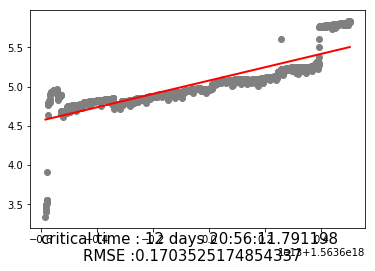

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
script-basic-java-sleep1min-leak
RUNNING : script-basic-java-sleep1min-leak
select value from node_memory_MemTotal_bytes where time >= '2019-07-19T12:25:23.172Z' AND time <= '2019-07-19T15:26:38.172Z'
METHOD 1 : Simple linear regression
3 days 14:10:38.882728
0.10027133962251761


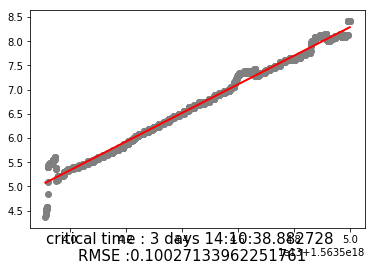

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
latest-basic-java-sleep1min-leak
RUNNING : latest-basic-java-sleep1min-leak
select value from node_memory_MemTotal_bytes where time >= '2019-07-25T05:18:00.64Z' AND time <= '2019-07-25T08:18:10.64Z'
METHOD 1 : Simple linear regression
1 days 06:03:14.948381
0.06555943936821527


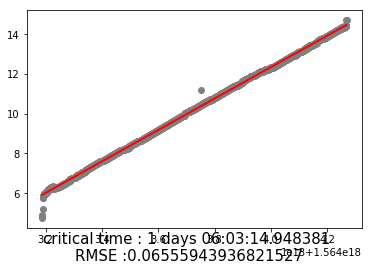

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
script-mem-alloc-cffi-leak-try3
RUNNING : script-mem-alloc-cffi-leak-try3
select value from node_memory_MemTotal_bytes where time >= '2019-07-20T00:38:13.62Z' AND time <= '2019-07-20T03:39:28.621Z'
METHOD 1 : Simple linear regression
1 days 06:42:32.810666
28.038371980112696


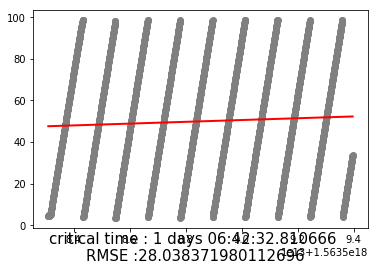

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
noodejs-event-emitter-leak
RUNNING : noodejs-event-emitter-leak
select value from node_memory_MemTotal_bytes where time >= '2019-07-22T05:11:39.471Z' AND time <= '2019-07-22T08:11:49.471Z'
METHOD 1 : Simple linear regression
4 days 07:30:00.919469
0.10927753259034752


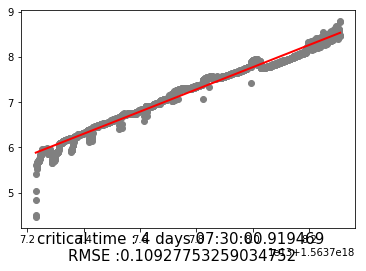

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
script-basic-python-sleep1min-verified-leak
RUNNING : script-basic-python-sleep1min-verified-leak
select value from node_memory_MemTotal_bytes where time >= '2019-07-19T18:31:55.291Z' AND time <= '2019-07-19T21:33:05.291Z'
METHOD 1 : Simple linear regression
5 days 02:46:05.792383
0.06488472213973076


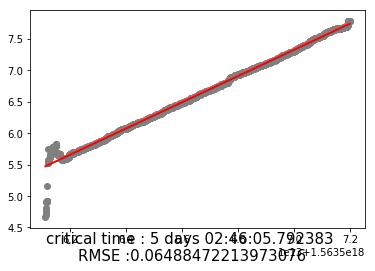

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
nodejs-basic-leak
RUNNING : nodejs-basic-leak
select value from node_memory_MemTotal_bytes where time >= '2019-07-22T18:11:01.579Z' AND time <= '2019-07-22T21:11:46.579Z'
METHOD 1 : Simple linear regression
35 days 16:35:43.664310
0.3300358962136489


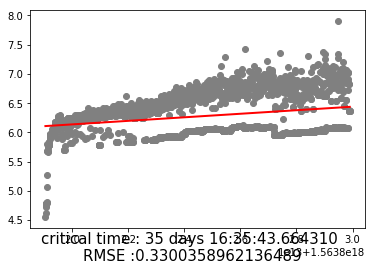

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
nodejs-gc-test-leakfix
RUNNING : nodejs-gc-test-leakfix
select value from node_memory_MemTotal_bytes where time >= '2019-07-20T09:48:41.477Z' AND time <= '2019-07-20T12:49:56.477Z'
METHOD 1 : Simple linear regression
53 days 02:26:26.709411
0.12362271975709081


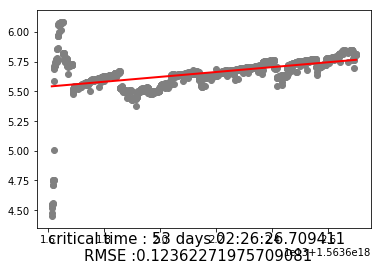

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
script-basic-java-sleep1min-leakfix
RUNNING : script-basic-java-sleep1min-leakfix
select value from node_memory_MemTotal_bytes where time >= '2019-07-19T21:35:03.516Z' AND time <= '2019-07-20T00:36:18.516Z'
METHOD 1 : Simple linear regression
14 days 15:53:40.232877
0.20474181744474038


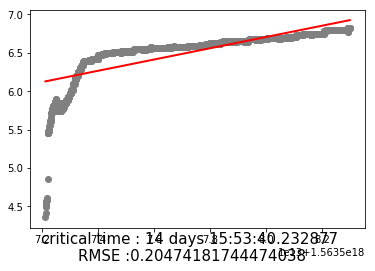

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
script-mem-alloc-cffi-leakfix
RUNNING : script-mem-alloc-cffi-leakfix
select value from node_memory_MemTotal_bytes where time >= '2019-07-19T15:28:37.552Z' AND time <= '2019-07-19T18:29:52.552Z'
METHOD 1 : Simple linear regression
30 days 07:41:13.434234
0.1013857766617711


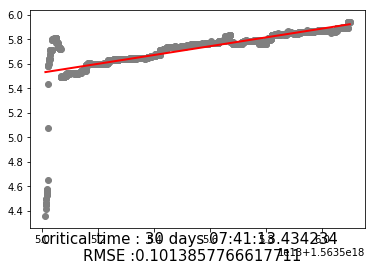

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
noodejs-event-emitter-leakfix
RUNNING : noodejs-event-emitter-leakfix
select value from node_memory_MemTotal_bytes where time >= '2019-07-24T12:43:11.554Z' AND time <= '2019-07-24T15:43:26.554Z'
METHOD 1 : Simple linear regression
31 days 06:14:13.827060
0.052702413768359345


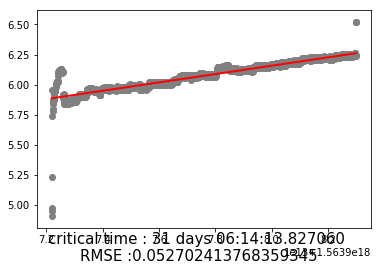

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
script-basic-python-sleep1min-verified-leakfix
RUNNING : script-basic-python-sleep1min-verified-leakfix
select value from node_memory_MemTotal_bytes where time >= '2019-07-20T06:45:33.63Z' AND time <= '2019-07-20T09:46:43.63Z'
METHOD 1 : Simple linear regression
32 days 17:24:40.879131
0.06648672126165059


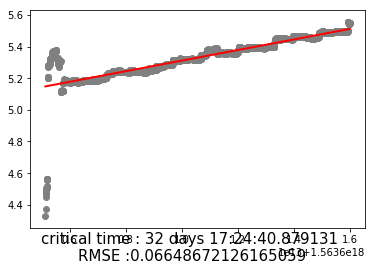

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
nodejs-basic-fix
RUNNING : nodejs-basic-fix
select value from node_memory_MemTotal_bytes where time >= '2019-07-23T05:13:18.819Z' AND time <= '2019-07-23T08:13:33.819Z'
METHOD 1 : Simple linear regression
13 days 08:46:54.167237
0.36383142939284585


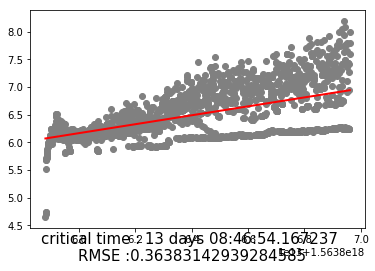

METHOD 2 : Multiple split Learning of Time Series
METHOD 3 : Simple Linear regression on Rolling window  of size : 50
METHOD 4 : change point detection : LR on high change points
script-nodejs-buffer-arr-push-app-regular
RUNNING : script-nodejs-buffer-arr-push-app-regular
select value from node_memory_MemTotal_bytes where time >= '2019-07-21T12:53:14.399Z' AND time <= '2019-07-21T15:54:19.399Z'


InfluxDBClientError: database not found: script-nodejs-buffer-arr-push-app-regular

<Figure size 432x288 with 0 Axes>

In [14]:
if __name__ == '__main__':
    # connect to the db
    # todo dbname must be parameterised to be passed as an argument
    for item in imagedict.keys():
        print(item)
        print("RUNNING : "+ item)
        dbname = item
        client = connect(item)
        
        #client = connect(dbname)
        host_mem_used_df = get_host_memory_usage(client)    

        used_df = host_mem_used_df[['time', 'used']].copy()

        # learning method 1
        print("METHOD 1 : Simple linear regression")
        fit_linear_model(used_df, "used")

        # method 2
        print("METHOD 2 : Multiple split Learning of Time Series")
        #multi_split_prediction(used_df, 'used')

        # method 3
        print("METHOD 3 : Simple Linear regression on Rolling window  of size : 50")
        #rolling_linear_regression(used_df, 'used')

        print("METHOD 4 : change point detection : LR on high change points")
        #detect_change_points(used_df, 'used')
        """
        # regular plot
        plot_df(host_mem_used_df, "host_mem", ['used'], 0, "Host Memory Usage Percentage"+item)

        container_mem_usage_df = get_container_memory_usage(client)
        plot_df(container_mem_usage_df, "container_mem", ['usage'], 0, "Container Memory Usage"+item)

        host_cpu_usage = get_host_cpu_usage(client)
        plot_df(host_cpu_usage, "host_cpu", ['percentage'], 100, "Host CPU Usage"+item)

        container_cpu_usage = get_container_cpu_usage(client)
        plot_df(container_cpu_usage, "container_cpu", ['percentage'], 0, "Container CPU Usage"+item)
        
        """


###### 